In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [46]:
file_path = '/Users/thomas/Desktop/hall_sensor_2024-07-11_00-38-51.csv'
file_path2 = '/Users/thomas/Desktop/hall_sensor_2024-07-11_04-31-40.csv'

# Import hall data
df1 = pd.read_csv(file_path)
df1['time'] = df1['time'].apply(lambda x: int(x))
df1 = df1[['time']]
df1['sensor'] = 'Hall'
df3 = pd.read_csv(file_path2)
df3['time'] = df3['time'].apply(lambda x: int(x))
df3 = df3[['time']]
df3['sensor'] = 'Hall'

# Import omega data
df2 = pd.read_csv(file_path.replace('hall','omega'))
df2['time'] = df2['time'].apply(lambda x: int(x))
df2 = df2[['time']]
df2['sensor'] = 'Omega'
df4 = pd.read_csv(file_path2.replace('hall','omega'))
df4['time'] = df4['time'].apply(lambda x: int(x))
df4 = df4[['time']]
df4['sensor'] = 'Omega'

# Add time in minutes relative to first tick
first_tick = min(df1.time[0]/1e9/60, df2.time[0]/1e9/60)
df1['time_min'] = df1['time']/1e9/60 - first_tick
df3['time_min'] = df3['time']/1e9/60 - first_tick
df2['time_min'] = df2['time']/1e9/60 - first_tick
df4['time_min'] = df4['time']/1e9/60 - first_tick

# Remove long break period between 1&2 and 3&4
break_time = list(df3.time_min)[0] - list(df1.time_min)[-1]
df3['time_min'] = df3['time_min'] - break_time
df4['time_min'] = df4['time_min'] - break_time

# Create the hall and omega dataframes
df_hall = pd.concat([df1, df3], ignore_index=True)
df_hall = df_hall.sort_values(by='time')
df_hall = df_hall.reset_index(drop=True)
df_hall['frequency'] = 1 / (df_hall['time'].diff().shift(-1)) * 1e9

df_omega = pd.concat([df2, df4], ignore_index=True)
df_omega = df_omega.sort_values(by='time')
df_omega = df_omega.reset_index(drop=True)
df_omega['frequency'] = 1 / (df_omega['time'].diff().shift(-1)) * 1e9

# Remove 9/10 hall points to accelerate process (just for visualisation!)
df_hall_full = df_hall
df_hall = df_hall.iloc[::10]
df_hall = df_hall.reset_index(drop=True)

# Merge the hall and omega dataframes
df = pd.concat([df_hall, df_omega], ignore_index=True)
df = df.sort_values(by='time')
df = df.reset_index(drop=True)

# Keep the full data for later
df_full = pd.concat([df_hall_full, df_omega], ignore_index=True)
df_full = df_full.sort_values(by='time')
df_full = df_full.reset_index(drop=True)
display(df_full)

,time,sensor,time_min,frequency
0,1609468153558211000,Omega,0.000000,0.029901
1,1609468155866447000,Hall,0.038471,33.788350
2,1609468155896043000,Hall,0.038964,33.443698
3,1609468155925944000,Hall,0.039462,33.700671
4,1609468155955617000,Hall,0.039957,33.670034
...,...,...,...,...
986279,1609492993640664000,Hall,304.998102,33.109294
986280,1609492993670867000,Hall,304.998606,33.519928
986281,1609492993700700000,Hall,304.999103,33.199429
986282,1609492993730821000,Hall,304.999605,32.998944


In [34]:
# Compute frequency - Hall
hall_times = list(df[df.sensor=='Hall'].time)
for i in range(len(hall_times)-1):
    frequency = 1/(hall_times[i+1]-hall_times[i])*1e9
    if i==0: 
        df.loc[df.time>=0, 'hall_frequency'] = frequency
        df.loc[df.time>=0, 'hall_GPM'] = frequency/7.5 * 0.264172
    df.loc[df.time>=hall_times[i], 'hall_frequency'] = frequency
    df.loc[df.time>=hall_times[i], 'hall_GPM'] = frequency/7.5 * 0.264172

# Compute frequency - Omega
omega_times = list(df[df.sensor=='Omega'].time)
for i in range(len(omega_times)-1):
    frequency = 1/(omega_times[i+1]-omega_times[i])*1e9
    if i==0: 
        df.loc[df.time>=0, 'omega_frequency'] = frequency
        df.loc[df.time>=0, 'omega_GPM'] = 0.1*frequency*60
    df.loc[df.time>=omega_times[i], 'omega_frequency'] = frequency
    df.loc[df.time>=omega_times[i], 'omega_GPM'] = 0.1*frequency*60

display(df)

,time,sensor,time_min,hall_frequency,hall_GPM,omega_frequency,omega_GPM
0,1609468153558211000,Omega,0.000000,3.383694,0.119184,0.029901,0.179408
1,1609468155866447000,Hall,0.038471,3.383694,0.119184,0.029901,0.179408
2,1609468156161982000,Hall,0.043396,3.363380,0.118468,0.029901,0.179408
3,1609468156459302000,Hall,0.048352,3.377363,0.118961,0.029901,0.179408
4,1609468156755391000,Hall,0.053286,3.367638,0.118618,0.029901,0.179408
...,...,...,...,...,...,...,...
99411,1609492992624438000,Hall,304.981165,3.333256,0.117407,0.054787,0.328722
99412,1609492992924445000,Hall,304.986166,3.353094,0.118106,0.054787,0.328722
99413,1609492993222677000,Hall,304.991136,3.350870,0.118027,0.054787,0.328722
99414,1609492993518860000,Omega,304.996072,3.350870,0.118027,0.054787,0.328722


,time,sensor,time_min,frequency,hall_frequency,omega_frequency
0,1609468153558211000,Omega,0.000000,0.029901,NaN,0.029901
1,1609468155866447000,Hall,0.038471,33.788350,33.788350,NaN
2,1609468156161982000,Hall,0.043396,33.815772,33.815772,NaN
3,1609468156459302000,Hall,0.048352,33.715442,33.715442,NaN
4,1609468156755391000,Hall,0.053286,33.832933,33.832933,NaN
...,...,...,...,...,...,...
99411,1609492992624438000,Hall,304.981165,33.463842,33.463842,NaN
99412,1609492992924445000,Hall,304.986166,33.283408,33.283408,NaN
99413,1609492993222677000,Hall,304.991136,33.675703,33.675703,NaN
99414,1609492993518860000,Omega,304.996072,NaN,NaN,NaN


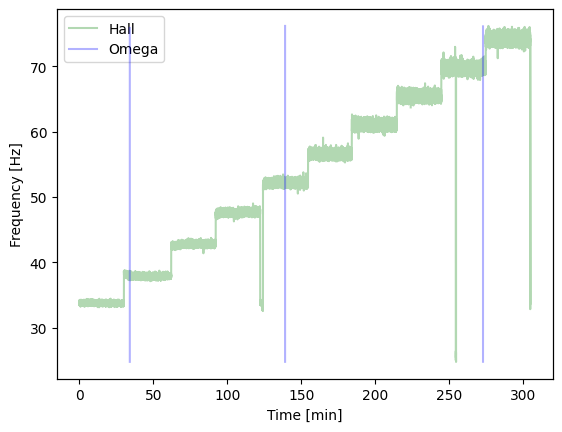

In [47]:
df['hall_frequency'] = df[df.sensor=='Hall'].frequency
df['omega_frequency'] = df[df.sensor=='Omega'].frequency
display(df)
# Filter out errors
#df = df[df.omega_frequency<0.1]
#df = df[df.omega_frequency>0.01]
#df = df[df.hall_frequency>3]

# Plot results
fig, ax = plt.subplots(1,1)
ax2 = ax.twinx()
ax.plot(list(df.time_min), list(df.hall_frequency), alpha=0.3, label=f'Hall', color='green')
ax2.plot(list(df.time_min), list(df.omega_frequency), alpha=0.3, label=f'Omega', color='blue')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [min]')
#ax.set_yticks([])
ax2.set_yticks([])
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2)
plt.show()

********************
0-30 min (30)
********************
Gallons during the section: 54
Gallons per tick: 0.0009039775
Average GPM: 1.8


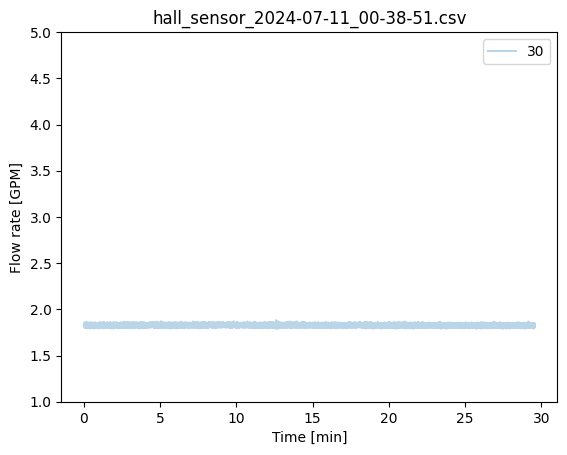

********************
34-60 min (35)
********************
Gallons during the section: 54
Gallons per tick: 0.0009288884
Average GPM: 2.077


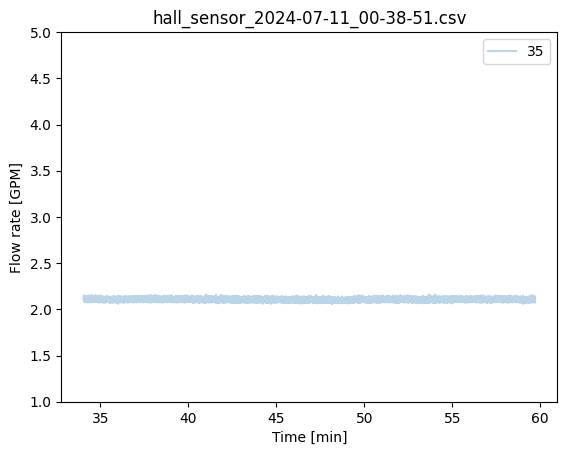

********************
64-90 min (40)
********************
Gallons during the section: 60
Gallons per tick: 0.0009163243
Average GPM: 2.308


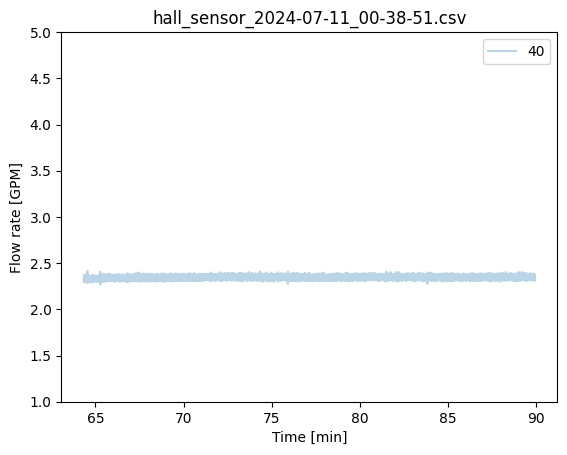

********************
94-120 min (45)
********************
Gallons during the section: 65
Gallons per tick: 0.0008916935
Average GPM: 2.5


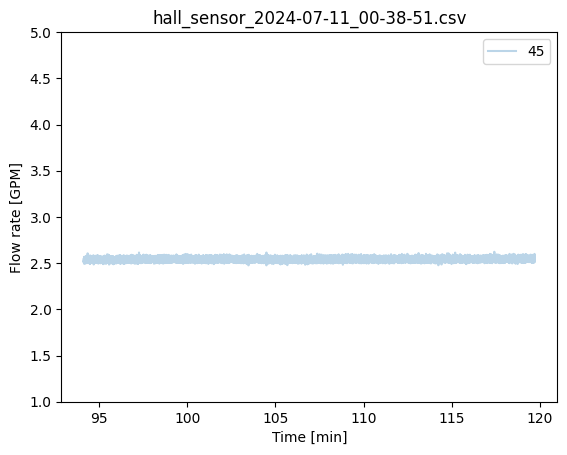

In [17]:
for section in range(4):
    
    # Get the full data
    df = df_full

    # Crop the data to the desired section
    min_time = section*30
    max_time = (section+1)*30
    min_time = min_time+4 if min_time>=30 else min_time
    print('*'*20 + f'\n{min_time}-{max_time} min ({30+section*5})\n' + '*'*20)

    # Crop by sections of 30 minutes
    df = df[df.time_min>=min_time]
    df = df[df.time_min<=max_time]

    # Crop between the first and last Omega ticks
    first_omega_tick = list(df[df.sensor=='Omega'].time)[0]
    last_omega_tick = list(df[df.sensor=='Omega'].time)[-1]
    df = df[df.time>=first_omega_tick]
    df = df[df.time<=last_omega_tick]

    # Count the gallons per tick
    gallons = len(df[df.sensor=='Omega'])
    print(f'Gallons during the section: {round(gallons,1)}')
    hall_gallons_per_tick = gallons / len(df[df.sensor=='Hall'])
    print(f'Gallons per tick: {round(hall_gallons_per_tick,10)}')
    average = gallons/30 if min_time<30 else gallons/26
    print(f'Average GPM: {round(average,3)}')
    
    # Compute GPMs
    hall_times = list(df[df.sensor=='Hall'].time)

    for i in range(len(hall_times)-1):
        frequency = 1/(hall_times[i+1]-hall_times[i])*1e9
        if i==0: 
            df.loc[df.time>=0, 'hall_freq'] = frequency
            df.loc[df.time>=0, 'hall_GPM'] = frequency/7.5 * 0.264172
            df.loc[df.time>=0, 'hall_GPM_gpt'] = hall_gallons_per_tick*frequency*60
        df.loc[df.time>=hall_times[i], 'hall_freq'] = frequency
        df.loc[df.time>=hall_times[i], 'hall_GPM'] = frequency/7.5 * 0.264172
        df.loc[df.time>=hall_times[i], 'hall_GPM_gpt'] = hall_gallons_per_tick*frequency*60

    # Plot results
    #plt.plot(list(df.time_min), list(df.hall_GPM), alpha=0.3, label=f'Hall with freq', color='green')
    plt.plot(list(df.time_min), list(df.hall_GPM_gpt), alpha=0.3, label=f'{30+section*5}')
    plt.title(file_path.split('/')[-1]) #+ f': {min_time}-{max_time} min')
    plt.ylabel('Flow rate [GPM]')
    plt.xlabel('Time [min]')
    plt.ylim([1,5])
    plt.legend()

    plt.show()